In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPool1D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

plt.style.use('ggplot')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
data = pd.read_csv(
    '../LSTM/dynamic_api_call_sequence_per_malware_100_0_306.csv/dynamic_api_call_sequence_per_malware_100_0_306.csv')

used_data = data.drop(['hash', 'malware'], axis=1)

print(data['malware'].value_counts())

malware
1    42797
0     1079
Name: count, dtype: int64


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    used_data,
    data['malware'],
    test_size=0.25,
    shuffle=True,
    random_state=42,
    # Ensures same class distribution in train and test sets
    stratify=data['malware']
)
X_train.shape

(32907, 100)

In [19]:
from sklearn.utils.class_weight import compute_class_weight
# Calculate class weights based on the imbalance in the dataset
class_weights = compute_class_weight(
    # This makes the class weight inversely proportional to class frequencies
    class_weight='balanced',
    classes=np.unique(y_train),  # Unique class labels (0 and 1 in your case)
    y=y_train  # Your target labels
)

# Convert class_weights into a dictionary
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Print the class weights to see the values
print("Class weights:", class_weight_dict)

Class weights: {0: 20.3380716934487, 1: 0.5126020312792074}


In [8]:
unique_api_calls = 307
model = Sequential(name="Cnn-Lstm_model")
model.add(Embedding(input_dim=unique_api_calls, output_dim=8,
                    input_length=X_train.shape[1], name='layer_embedding'))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=9, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(LSTM(units=512, return_sequences=False, dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [10]:
model.summary()

Model: "Cnn-Lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_embedding (Embedding)  (None, 100, 8)           2456      
                                                                 
 batch_normalization (BatchN  (None, 100, 8)           32        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           2336      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 512)               1116160   
                                                                 
 dense (Dense)               (None, 1)              

In [20]:
optimizer = Adam(lr=.0001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=512,
    class_weight=class_weight_dict  # Apply class weights here
)

c:\Users\youssef khaled\.conda\envs\tensorflow_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/150
52/52 [==============================] - 5s 56ms/step - loss: 0.0455 - accuracy: 0.9909 - val_loss: 0.0445 - val_accuracy: 0.9883
Epoch 2/150
52/52 [==============================] - 3s 48ms/step - loss: 0.0556 - accuracy: 0.9830 - val_loss: 0.0437 - val_accuracy: 0.9863
Epoch 3/150
52/52 [==============================] - 3s 48ms/step - loss: 0.0385 - accuracy: 0.9870 - val_loss: 0.0437 - val_accuracy: 0.9857
Epoch 4/150
52/52 [==============================] - 3s 48ms/step - loss: 0.0320 - accuracy: 0.9902 - val_loss: 0.0503 - val_accuracy: 0.9871
Epoch 5/150
52/52 [==============================] - 3s 48ms/step - loss: 0.0333 - accuracy: 0.9906 - val_loss: 0.0565 - val_accuracy: 0.9862
Epoch 6/150
52/52 [==============================] - 3s 48ms/step - loss: 0.0349 - accuracy: 0.9888 - val_loss: 0.0538 - val_accuracy: 0.9859
Epoch 7/150
52/52 [==============================] - 3s 49ms/step - loss: 0.0388 - accuracy: 0.9883 - val_loss: 0.0501 - val_accuracy: 0.9844
Epoch 

In [ ]:
# model.save('behavioral-malware-detection-based-on-api-calls_model.h5')

Text(0.5, 0, 'Epochs')

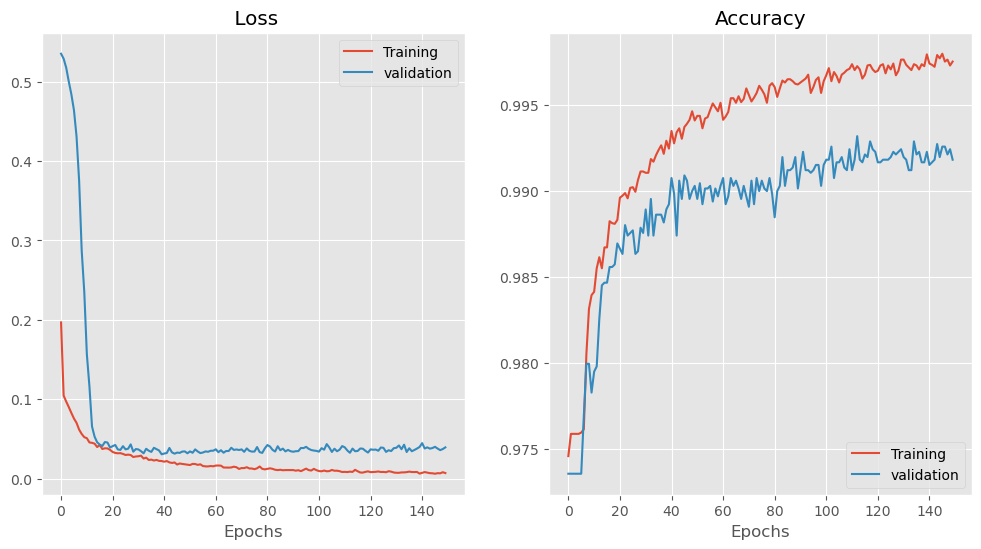

In [13]:
fig, ax = plt.subplots(1, 2, figsize=[12, 6])
ax[0].plot(history.history["loss"])
ax[0].plot(history.history["val_loss"])
ax[0].set_title(" Loss")
ax[0].legend(("Training", "validation"), loc="upper right")
ax[0].set_xlabel("Epochs")
ax[1].plot(history.history["accuracy"])
ax[1].plot(history.history["val_accuracy"])
ax[1].legend(("Training", "validation"), loc="lower right")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")

In [16]:
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels using a threshold of 0.5
y_pred = (y_pred_probs > 0.5).astype(int)

print("CNN_LSTM model classification report: \n\n {}".format(
    classification_report(np.array(y_test), y_pred.flatten())))

343/343 [==============================] - 1s 4ms/step
CNN_LSTM model classification report: 

               precision    recall  f1-score   support

           0       0.92      0.76      0.83       270
           1       0.99      1.00      1.00     10699

    accuracy                           0.99     10969
   macro avg       0.96      0.88      0.91     10969
weighted avg       0.99      0.99      0.99     10969



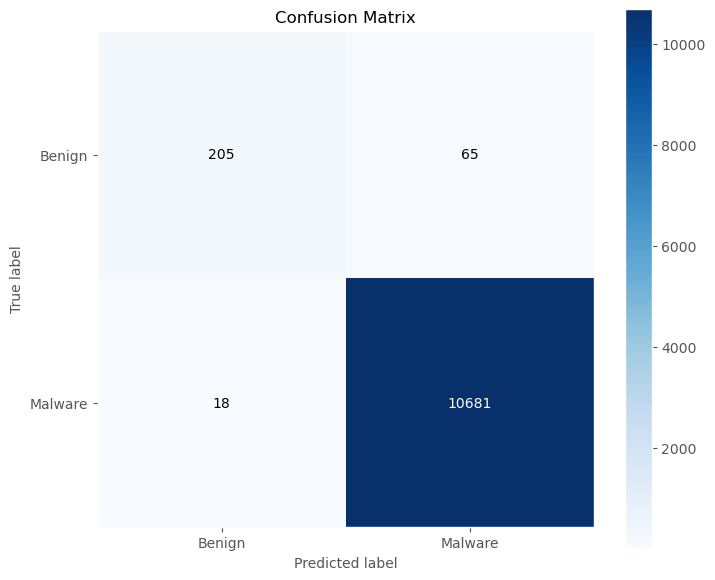

In [17]:
ax = skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(8, 7))
tickx = ax.set_xticklabels(['Benign', 'Malware'])
ticky = ax.set_yticklabels(['Benign', 'Malware'])